# Import libraries and dependencies

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movenet/tensorflow2/singlepose-lightning/4/saved_model.pb
/kaggle/input/movenet/tensorflow2/singlepose-lightning/4/variables/variables.index
/kaggle/input/movenet/tensorflow2/singlepose-lightning/4/variables/variables.data-00000-of-00001


In [11]:
# Import primary libraries
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Import secondary libraries
from io import BytesIO
from matplotlib.collections import LineCollection
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import PIL.ImageOps

# Import tertiary libraries; generate warnings
import requests
import warnings
warnings.filterwarnings('ignore')

# Define settings

In [12]:
# Define keypoint names and connections
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [13]:
# Define the connections between keypoints for skeleton visualization
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',     # nose to left_eye
    (0, 2): 'c',     # nose to right_eye
    (1, 3): 'm',     # left_eye to left_ear
    (2, 4): 'c',     # right_eye to right_ear
    (0, 5): 'm',     # nose to left_shoulder
    (0, 6): 'c',     # nose to right_shoulder
    (5, 7): 'm',     # left_shoulder to left_elbow
    (7, 9): 'm',     # left_elbow to left_wrist
    (6, 8): 'c',     # right_shoulder to right_elbow
    (8, 10): 'c',    # right_elbow to right_wrist
    (5, 6): 'y',     # left_shoulder to right_shoulder
    (5, 11): 'm',    # left_shoulder to left_hip
    (6, 12): 'c',    # right_shoulder to right_hip
    (11, 12): 'y',   # left_hip to right_hip
    (11, 13): 'm',   # left_hip to left_knee
    (13, 15): 'm',   # left_knee to left_ankle
    (12, 14): 'c',   # right_hip to right_knee
    (14, 16): 'c'    # right_knee to right_ankle
}

In [14]:
def load_movenet_model():
    """Load MoveNet SinglePose Lightning model from Kaggle dataset"""
    print("Loading MoveNet SinglePose Lightning model...")
    try:
        # Try to load from Kaggle dataset path
        model_path = '/kaggle/input/movenet/tensorflow2/singlepose-lightning/4'
        model = tf.saved_model.load(model_path)
        print(f"✓ Model loaded successfully from Kaggle dataset")
    except:
        # Fallback to TensorFlow Hub if Kaggle path not available
        print("Kaggle dataset not found, loading from TensorFlow Hub...")
        model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        print(f"✓ Model loaded successfully from TensorFlow Hub")
    
    return model

def preprocess_image(image_path):
    """Load and preprocess image for MoveNet"""
    if image_path.startswith('http'):
        # Download image from URL
        response = requests.get(image_path)
        image = PIL.Image.open(BytesIO(response.content)).convert('RGB')
    else:
        # Load local image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image)
        image = PIL.Image.fromarray(image.numpy())

    # Convert to RGB if necessary
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Keep original for display
    original_image = np.array(image)
    
    # Resize the image resolution to 192x192 for the model
    input_size = 192
    image = PIL.ImageOps.fit(image, (input_size, input_size), PIL.Image.LANCZOS)
    image_array = np.array(image)
    
    # Convert to tensor and add batch dimension
    input_image = tf.expand_dims(image_array, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)
    
    return input_image, original_image, image_array

def run_inference(model, input_image):
    """Run pose detection inference"""
    # Get the model's callable signature
    movenet = model.signatures['serving_default']
    
    # Run model inference
    outputs = movenet(input_image)
    
    # Extract keypoints from the output
    keypoints_with_scores = outputs['output_0'].numpy()
    
    return keypoints_with_scores

def draw_keypoints(image, keypoints, confidence_threshold=0.3):
    """Draw keypoints on image"""
    image_copy = image.copy()
    height, width = image.shape[:2]

    # Draw keypoints
    for idx, (y, x, confidence) in enumerate(keypoints[0][0].reshape(-1, 3)):
        if confidence > confidence_threshold:
            # Convert normalized coordinates to pixel coordinates
            x_pixel = int(x * width)
            y_pixel = int(y * height)
            
            # Draw keypoint circle
            cv2.circle(image_copy, (x_pixel, y_pixel), 5, (0, 255, 0), -1)
            cv2.circle(image_copy, (x_pixel, y_pixel), 5, (255, 255, 255), 2)
            
            # Add keypoint number
            cv2.putText(image_copy, str(idx), (x_pixel - 10, y_pixel - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return image_copy

def draw_skeleton(image, keypoints, confidence_threshold=0.3):
    """Draw skeleton connections on image"""
    image_copy = image.copy()
    height, width = image.shape[:2]
    
    keypoints_array = keypoints[0][0].reshape(-1, 3)

    # Draw skeleton connections
    for edge, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints_array[p1]
        y2, x2, c2 = keypoints_array[p2]
        
        if c1 > confidence_threshold and c2 > confidence_threshold:
            x1_pixel = int(x1 * width)
            y1_pixel = int(y1 * height)
            x2_pixel = int(x2 * width)
            y2_pixel = int(y2 * height)
            
            # Convert matplotlib color to BGR for OpenCV
            color_bgr = {
                'm': (255, 0, 255),  # Magenta
                'c': (255, 255, 0),  # Cyan
                'y': (0, 255, 255),  # Yellow
            }.get(color, (0, 255, 0))
            
            cv2.line(image_copy, (x1_pixel, y1_pixel), (x2_pixel, y2_pixel), 
                    color_bgr, 2, cv2.LINE_AA)

    # Draw keypoints on top of skeleton
    image_with_skeleton = draw_keypoints(image_copy, keypoints, confidence_threshold)
    
    return image_with_skeleton

def create_sample_image():
    """Create a sample image with a stick figure for testing"""
    # Create a white background
    img = np.ones((400, 400, 3), dtype=np.uint8) * 255
    
    # Draw a simple stick figure (this won't be detected well, but shows the process)
    # Head
    cv2.circle(img, (200, 80), 30, (0, 0, 0), 2)
    # Body
    cv2.line(img, (200, 110), (200, 230), (0, 0, 0), 2)
    # Left arm
    cv2.line(img, (200, 140), (150, 180), (0, 0, 0), 2)
    # Right arm
    cv2.line(img, (200, 140), (250, 180), (0, 0, 0), 2)
    # Left leg
    cv2.line(img, (200, 230), (170, 330), (0, 0, 0), 2)
    # Right leg
    cv2.line(img, (200, 230), (230, 330), (0, 0, 0), 2)

    # Save as a temporary file first
    cv2.imwrite('/tmp/sample_stick_figure.jpg', img)
    return '/tmp/sample_stick_figure.jpg'

# Download the sample image

In [15]:
def download_sample_images():
    """Download real sample images for better demonstration"""
    sample_urls = [
        "https://images.pexels.com/photos/1199590/pexels-photo-1199590.jpeg?auto=compress&cs=tinysrgb&w=640",  # Person exercising
        "https://images.pexels.com/photos/3822906/pexels-photo-3822906.jpeg?auto=compress&cs=tinysrgb&w=640",  # Person in yoga pose
    ]
    return sample_urls

# Generate charts

In [16]:
def visualize_keypoint_confidence(keypoints):
    """Create a bar chart of keypoint confidences"""
    keypoint_names = list(KEYPOINT_DICT.keys())
    confidences = keypoints[0][0].reshape(-1, 3)[:, 2]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(keypoint_names)), confidences)
    
    # Color bars based on confidence
    for i, bar in enumerate(bars):
        if confidences[i] > 0.5:
            bar.set_color('green')
        elif confidences[i] > 0.3:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    ax.set_xlabel('Keypoint')
    ax.set_ylabel('Confidence Score')
    ax.set_title('Keypoint Detection Confidence Scores')
    ax.set_xticks(range(len(keypoint_names)))
    ax.set_xticklabels(keypoint_names, rotation=45, ha='right')
    ax.axhline(y=0.3, color='r', linestyle='--', label='Threshold (0.3)')
    ax.axhline(y=0.5, color='g', linestyle='--', label='High Confidence (0.5)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

In [17]:
def process_and_display(model, image_source, title="Pose Detection"):
    """Process an image and display results"""
    print(f"\nProcessing: {title}")
    print("-" * 50)
    
    # Preprocess image
    input_tensor, original_image, resized_image = preprocess_image(image_source)
    
    # Run inference
    keypoints = run_inference(model, input_tensor)
    
    # Create visualizations
    image_with_keypoints = draw_keypoints(resized_image, keypoints)
    image_with_skeleton = draw_skeleton(resized_image, keypoints)
    
    # Display results
    fig = plt.figure(figsize=(20, 10))

    # Original image
    ax1 = plt.subplot(2, 3, 1)
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Resized image resolution
    ax2 = plt.subplot(2, 3, 2)
    ax2.imshow(resized_image)
    ax2.set_title('Model Input (192x192)')
    ax2.axis('off')

    # Generate keypoints only
    ax3 = plt.subplot(2, 3, 3)
    ax3.imshow(image_with_keypoints)
    ax3.set_title('Detected Keypoints')
    ax3.axis('off')

    # Display full skeletons imagery
    ax4 = plt.subplot(2, 3, 4)
    ax4.imshow(image_with_skeleton)
    ax4.set_title('Full Skeleton Visualization')
    ax4.axis('off')

    # Confidence scores
    ax5 = plt.subplot(2, 3, 5)
    confidences = keypoints[0][0].reshape(-1, 3)[:, 2]
    keypoint_names = list(KEYPOINT_DICT.keys())
    bars = ax5.barh(range(len(keypoint_names)), confidences)
    for i, bar in enumerate(bars):
        color = 'green' if confidences[i] > 0.5 else 'orange' if confidences[i] > 0.3 else 'red'
        bar.set_color(color)
    ax5.set_yticks(range(len(keypoint_names)))
    ax5.set_yticklabels(keypoint_names)
    ax5.set_xlabel('Confidence Score')
    ax5.set_title('Keypoint Confidence Scores')
    ax5.axvline(x=0.3, color='r', linestyle='--', alpha=0.5)
    ax5.set_xlim([0, 1])
    ax5.grid(True, alpha=0.3)

    # Keypoint coordinates table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('tight')
    ax6.axis('off')

    # Create table data
    table_data = []
    for i, name in enumerate(keypoint_names):
        y, x, conf = keypoints[0][0].reshape(-1, 3)[i]
        if conf > 0.3:
            table_data.append([name[:12], f'{x:.3f}', f'{y:.3f}', f'{conf:.3f}'])
    
    if table_data:
        table = ax6.table(cellText=table_data,
                         colLabels=['Keypoint', 'X', 'Y', 'Conf'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        ax6.set_title('Detected Keypoint Coordinates')
    
    plt.suptitle(f'MoveNet SinglePose Lightning - {title}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print statistics
    detected_keypoints = np.sum(confidences > 0.3)
    avg_confidence = np.mean(confidences[confidences > 0.3]) if detected_keypoints > 0 else 0
    
    print(f"✓ Detected {detected_keypoints}/17 keypoints")
    print(f"✓ Average confidence: {avg_confidence:.3f}")
    print(f"✓ Max confidence: {np.max(confidences):.3f}")
    print(f"✓ Min confidence: {np.min(confidences):.3f}")

MoveNet SinglePose Lightning - Complete Kaggle Demo
Loading MoveNet SinglePose Lightning model...
✓ Model loaded successfully from Kaggle dataset

Testing with Sample Images

Processing: Sample Image 1
--------------------------------------------------


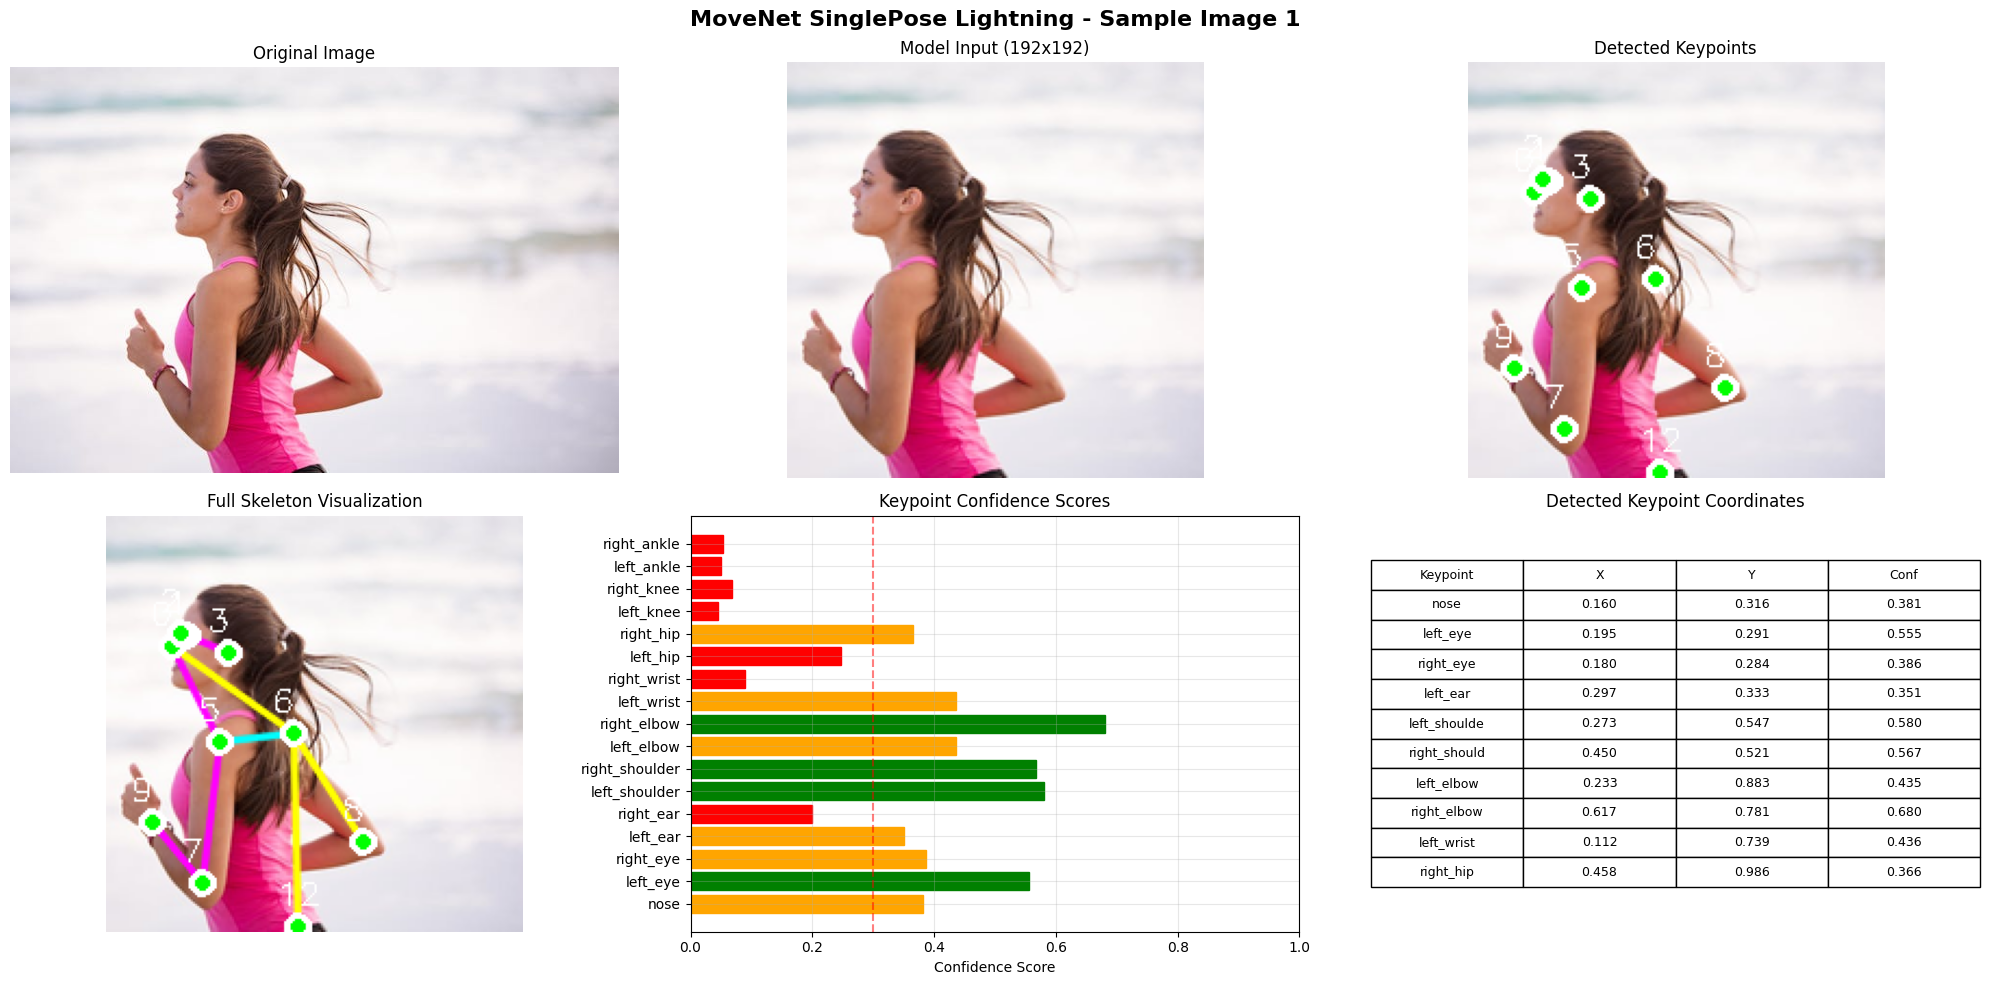

✓ Detected 10/17 keypoints
✓ Average confidence: 0.474
✓ Max confidence: 0.680
✓ Min confidence: 0.045

Processing: Sample Image 2
--------------------------------------------------


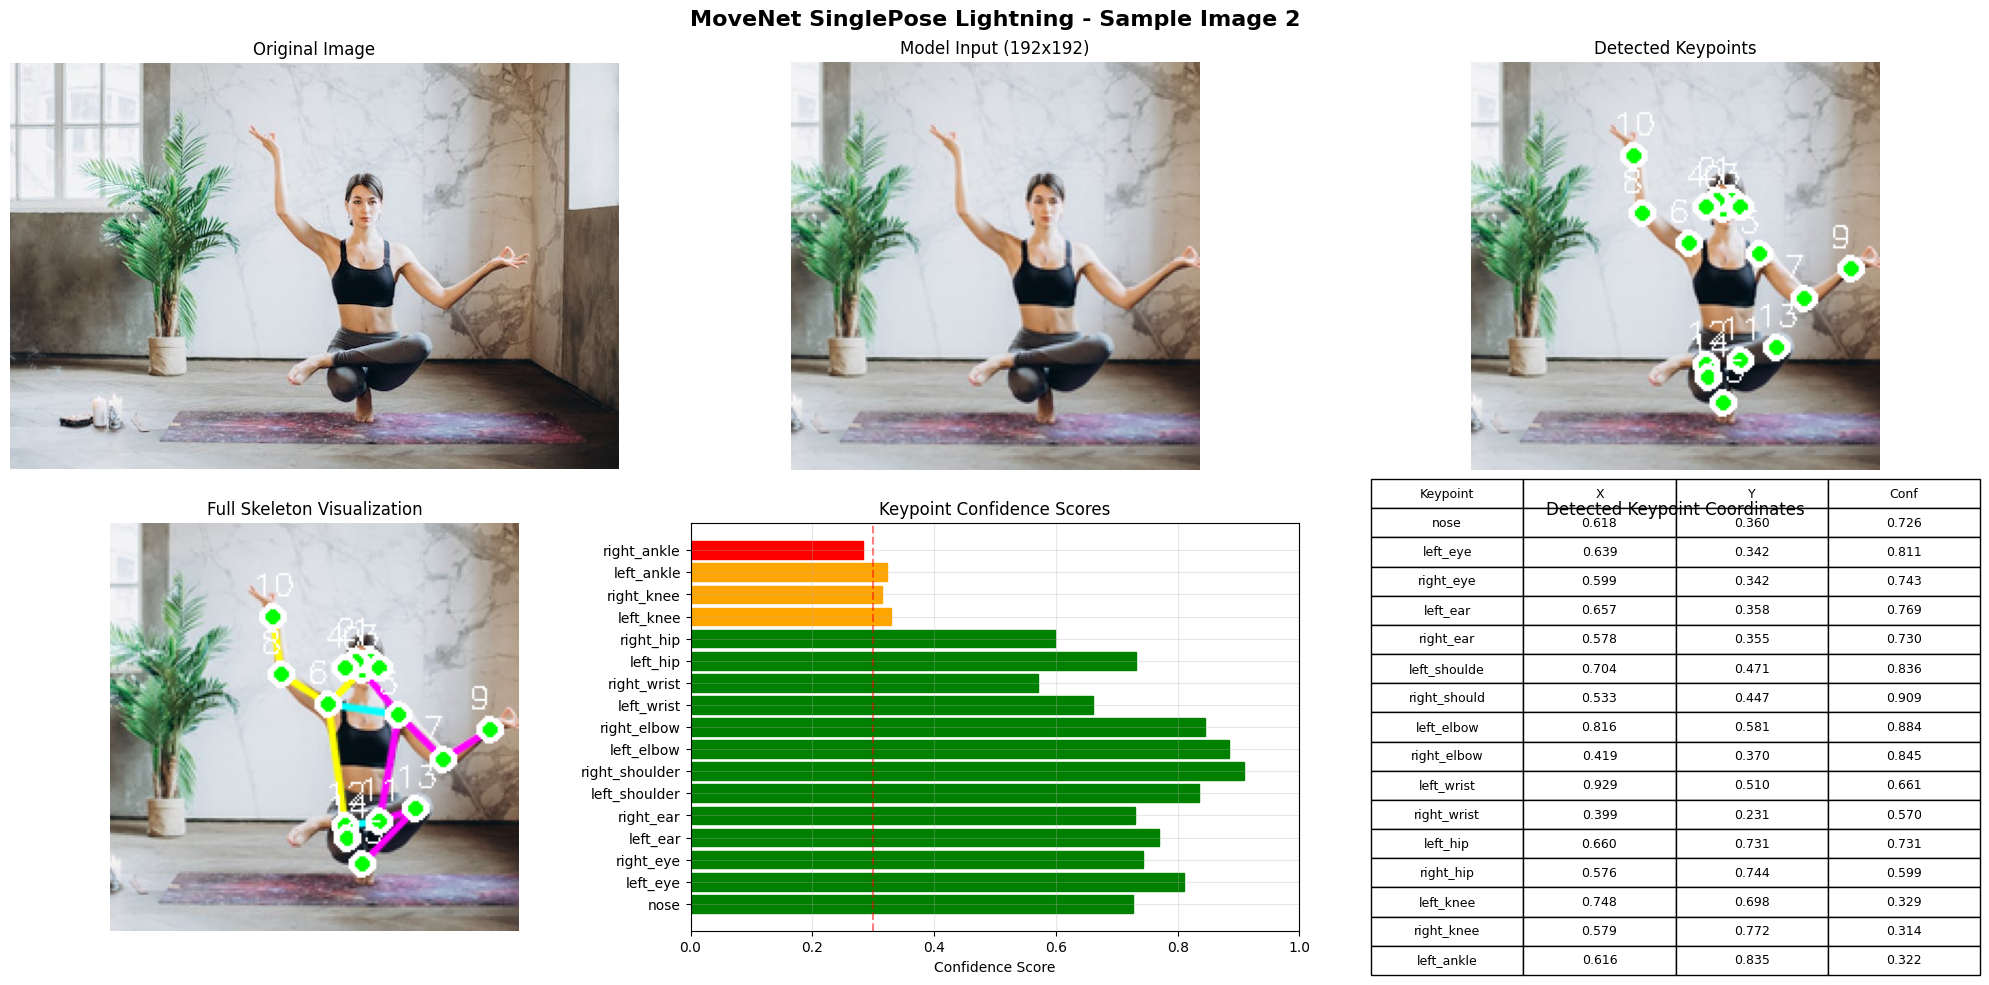

✓ Detected 16/17 keypoints
✓ Average confidence: 0.674
✓ Max confidence: 0.909
✓ Min confidence: 0.283

Testing with Synthetic Stick Figure

Processing: Synthetic Stick Figure
--------------------------------------------------


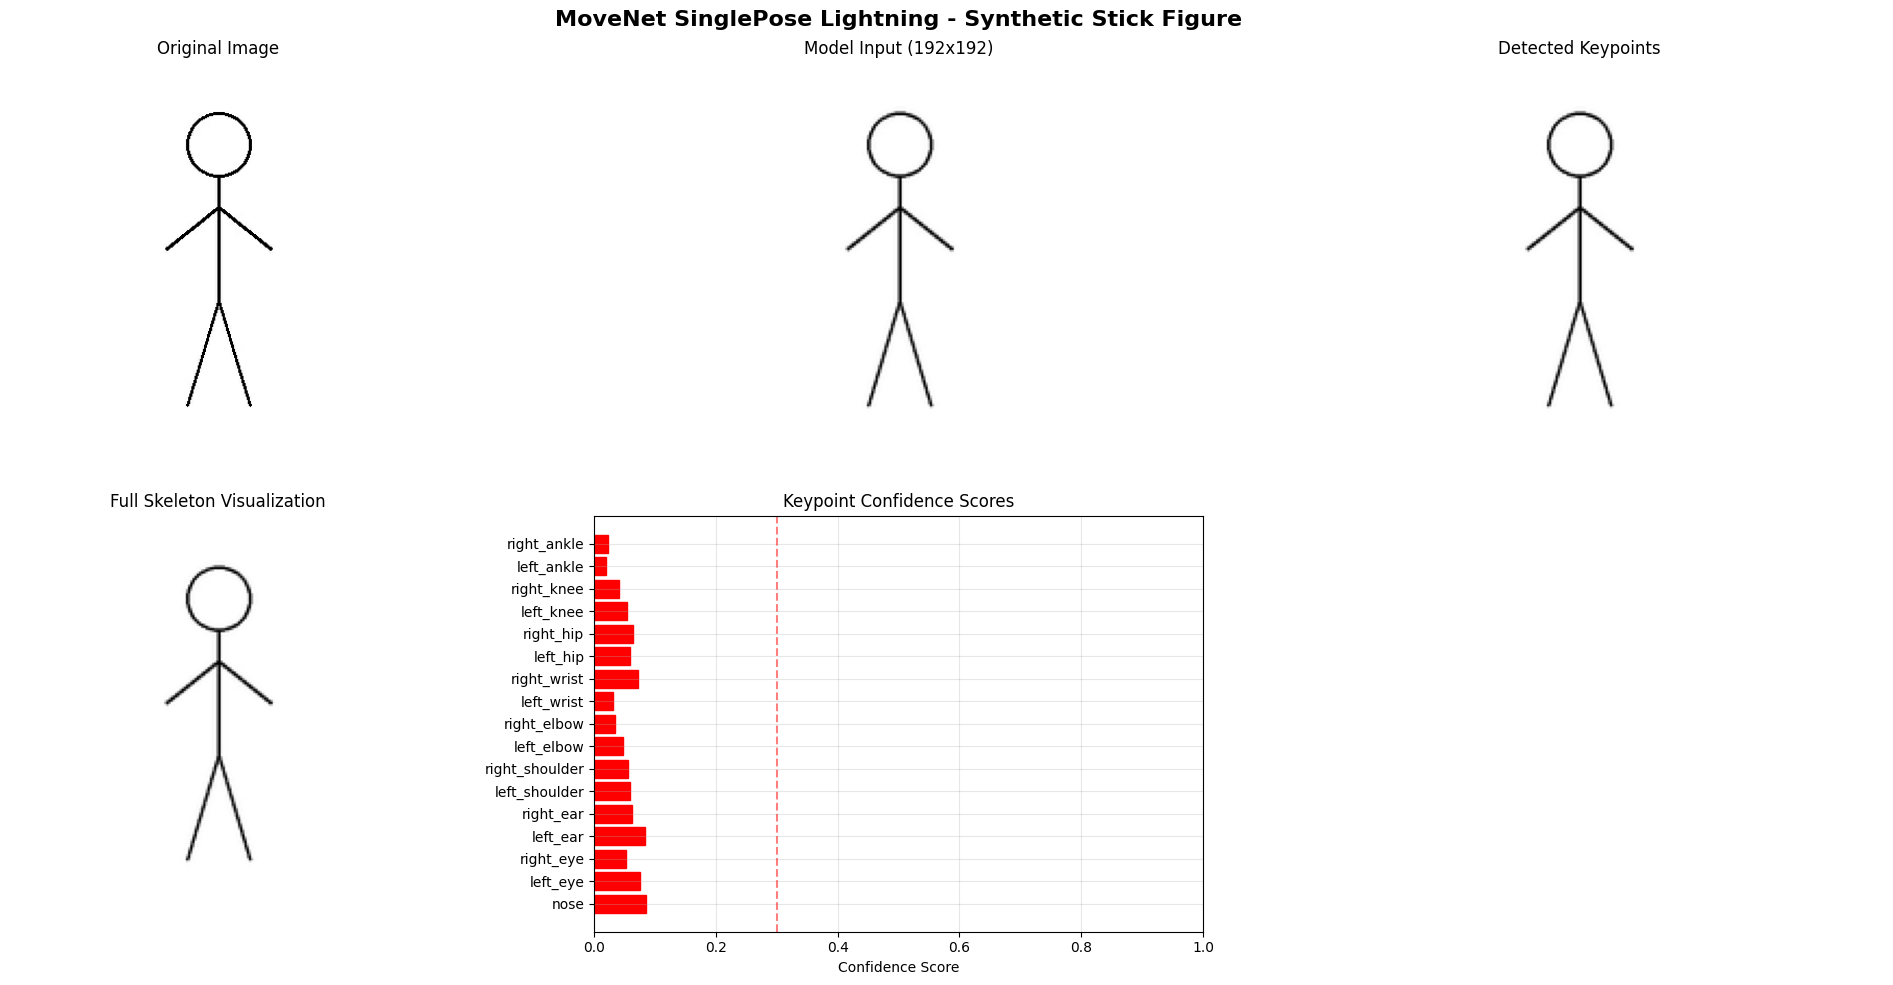

✓ Detected 0/17 keypoints
✓ Average confidence: 0.000
✓ Max confidence: 0.085
✓ Min confidence: 0.020

Batch Processing Demonstration
Processing batch of 3 images...
  Image 1: Detected 3/17 keypoints
  Image 2: Detected 0/17 keypoints
  Image 3: Detected 0/17 keypoints

Performance Analysis
Average inference time: 24.13 ms
Min inference time: 22.88 ms
Max inference time: 25.98 ms
Theoretical FPS: 41.4

Model Information
Model: MoveNet SinglePose Lightning
Input shape: (1, 192, 192, 3)
Output shape: (1, 1, 51) - 17 keypoints × 3 values (y, x, confidence)
Keypoints detected: 17 (full body)
Architecture: MobileNetV2 with custom heads
Designed for: Real-time pose detection on edge devices

Demo Complete!


In [18]:
def main():
    """Main execution function"""
    print("=" * 60)
    print("MoveNet SinglePose Lightning - Complete Kaggle Demo")
    print("=" * 60)

    # 1st step: Load the model
    model = load_movenet_model()

    # 2nd step: Test with the sample images
    print("\n" + "=" * 60)
    print("Testing with Sample Images")
    print("=" * 60)

    # 3rd step: Retrieve sample images
    sample_urls = download_sample_images()

    # 4th step: Process each samples
    for i, url in enumerate(sample_urls, 1):
        try:
            process_and_display(model, url, f"Sample Image {i}")
        except Exception as e:
            print(f"Error processing sample {i}: {e}")

    # 5th step: Create and test with the synthetic image
    print("\n" + "=" * 60)
    print("Testing with Synthetic Stick Figure")
    print("=" * 60)
    
    try:
        sample_path = create_sample_image()
        process_and_display(model, sample_path, "Synthetic Stick Figure")
    except Exception as e:
        print(f"Error with synthetic image: {e}")

    # 6th step: Batch processing example
    print("\n" + "=" * 60)
    print("Batch Processing Demonstration")
    print("=" * 60)
    
    # Create multiple synthetic images with different poses
    batch_images = []
    for i in range(3):
        img = np.ones((192, 192, 3), dtype=np.uint8) * 255
        # Add some random shapes to simulate different "poses"
        cv2.circle(img, (96 + i*20, 50), 20, (0, 0, 0), -1)
        cv2.rectangle(img, (86 + i*20, 70), (106 + i*20, 150), (0, 0, 0), -1)
        batch_images.append(img)
    
    # Process batch
    batch_tensor = tf.stack([tf.cast(img, tf.int32) for img in batch_images])

    print(f"Processing batch of {len(batch_images)} images...")
    for i, img_tensor in enumerate(tf.unstack(batch_tensor)):
        img_tensor = tf.expand_dims(img_tensor, 0)
        keypoints = run_inference(model, img_tensor)
        confidences = keypoints[0][0].reshape(-1, 3)[:, 2]
        detected = np.sum(confidences > 0.3)
        print(f"  Image {i+1}: Detected {detected}/17 keypoints")

    # 7th step: Performance analysis
    print("\n" + "=" * 60)
    print("Performance Analysis")
    print("=" * 60)

    # Measure inference time
    import time

    # Create test image
    test_image = tf.ones((1, 192, 192, 3), dtype=tf.int32)
    
    # Warm up
    for _ in range(3):
        _ = run_inference(model, test_image)
    
    # Measure
    times = []
    for _ in range(10):
        start = time.time()
        _ = run_inference(model, test_image)
        times.append((time.time() - start) * 1000)

    print(f"Average inference time: {np.mean(times):.2f} ms")
    print(f"Min inference time: {np.min(times):.2f} ms")
    print(f"Max inference time: {np.max(times):.2f} ms")
    print(f"Theoretical FPS: {1000/np.mean(times):.1f}")

    # Model information
    print("\n" + "=" * 60)
    print("Model Information")
    print("=" * 60)
    print("Model: MoveNet SinglePose Lightning")
    print("Input shape: (1, 192, 192, 3)")
    print("Output shape: (1, 1, 51) - 17 keypoints × 3 values (y, x, confidence)")
    print("Keypoints detected: 17 (full body)")
    print("Architecture: MobileNetV2 with custom heads")
    print("Designed for: Real-time pose detection on edge devices")
    
    print("\n" + "=" * 60)
    print("Demo Complete!")
    print("=" * 60)

if __name__ == "__main__":
    main()